# Collaborative filtering project

In this project, the task is to create a paper recommendation system. The system consists of 10,000 scientists and 1,000 papers. Scientists give ratings between 1–5 to the papers that they read. Since not all scientists have read every paper, we only have a limited amount of observations of these ratings. Additionally, each scientist has a wishlist of papers that they would like to read in the future. Your task is to fill in the missing observations using the provided rating and wishlist data, such that we can recommend papers to scientists that we expect them to rate highly.

More specifically, there are three data sources:
 - `train_tbr.csv` containing wishlist data.
 - `train_ratings.csv` containing observed rating data.
 - `sample_submission.csv` containing (scientist, paper) pairs that have to be rated for the evaluation of your method.

The data is available at `/cluster/courses/cil/collaborative_filtering/data` and an environment has been prepared for you at `/cluster/courses/cil/envs/collaborative_filtering`. You can activate the environment in your shell by running:
```bash
conda activate /cluster/courses/cil/envs/collaborative_filtering
```
If you wish to use notebooks on the cluster, you need to set the Environment path to `/cluster/courses/cil/envs/collaborative_filtering/bin` and load the `cuda/12.6` module.

**Evaluation**: Your models are evaluated using the root mean-squared error (RMSE) metric. Your grade is determined by a linear interpolation between the easy (grade 4) and hard (grade 6) baselines.

**Rules**: You are only allowed to use the data provided in `train_tbr.csv` and `train_ratings.csv` to make your predictions of `sample_submission.csv`. You are not allowed to use external data sources. But, you are allowed to use pre-trained models, as long as they are available publicly. Furthermore, no external API calls are allowed, except for downloading the weights of pre-trained models.

**We will verify your code for plagiarism and using solutions from previous years.**

[Link to Kaggle competition](https://www.kaggle.com/competitions/ethz-cil-collaborative-filtering-2025)


In [137]:
from typing import Tuple, Callable

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import os

Make sure that results are reproducible by using a seed.

In [138]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Helper functions

In [139]:
DATA_DIR = "."


def read_data_df() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Reads in data and splits it into training and validation sets with a 75/25 split."""
    
    df = pd.read_csv(os.path.join(DATA_DIR, "train_ratings.csv"))

    # Split sid_pid into sid and pid columns
    df[["sid", "pid"]] = df["sid_pid"].str.split("_", expand=True)
    df = df.drop("sid_pid", axis=1)
    df["sid"] = df["sid"].astype(int)
    df["pid"] = df["pid"].astype(int)
    
    # Split into train and validation dataset
    train_df, valid_df = train_test_split(df, test_size=0.25)
    return train_df, valid_df


def read_data_matrix(df: pd.DataFrame) -> np.ndarray:
    """Returns matrix view of the training data, where columns are scientists (sid) and
    rows are papers (pid)."""

    return df.pivot(index="sid", columns="pid", values="rating").values


def read_wishlist_df() -> pd.DataFrame:
    """Reads in the wishlist data (train_tbr.csv)."""
    
    tbr_df = pd.read_csv(os.path.join(DATA_DIR, "train_tbr.csv"))
    # Ensure sid and pid are integers
    tbr_df["sid"] = tbr_df["sid"].astype(int)
    tbr_df["pid"] = tbr_df["pid"].astype(int)
    return tbr_df


def read_wishlist_matrix(df: pd.DataFrame) -> np.ndarray:
    """Returns matrix view of the wishlist data.
    Rows are scientists (sid), columns are papers (pid).
    Values are 1 if the paper is on the wishlist, NaN otherwise."""
    
    # Add a temporary column with value 1 for pivoting
    df_copy = df.copy()
    df_copy['wishlisted'] = 1


    all_sids = pd.Index(range(10000))
    wishlist_matrix = df_copy.pivot(index="sid", columns="pid", values="wishlisted")
    wishlist_matrix = wishlist_matrix.reindex(all_sids)

    return wishlist_matrix.values

def evaluate(valid_df: pd.DataFrame, pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> float:
    """
    Inputs:
        valid_df: Validation data, returned from read_data_df for example.
        pred_fn: Function that takes in arrays of sid and pid and outputs their rating predictions.

    Outputs: Validation RMSE
    """
    
    preds = pred_fn(valid_df["sid"].values, valid_df["pid"].values)
    return root_mean_squared_error(valid_df["rating"].values, preds)


def make_submission(pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray], filename: os.PathLike):
    """Makes a submission CSV file that can be submitted to kaggle.

    Inputs:
        pred_fn: Function that takes in arrays of sid and pid and outputs a score.
        filename: File to save the submission to.
    """
    
    df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

    # Get sids and pids
    sid_pid = df["sid_pid"].str.split("_", expand=True)
    sids = sid_pid[0]
    pids = sid_pid[1]
    sids = sids.astype(int).values
    pids = pids.astype(int).values
    
    df["rating"] = pred_fn(sids, pids)
    df.to_csv(filename, index=False)

## Singular value decomposition

For the first method in this introduction, we will make use of the singular value decomposition (SVD) to construct the optimal rank-$k$ approximation (when measuring the Frobenius norm as error), according to the Eckart-Young theorem. Since the matrix needs to be fully observed in order to make use of SVD, we need to impute the missing values. In this case, we impute values with $3$.

In [140]:
def impute_values(mat: np.ndarray) -> np.ndarray:
    return np.nan_to_num(mat, nan=3.0)

In [141]:
train_ratings_df, valid_ratings_df = read_data_df()
train_wishlist_df = read_wishlist_df()

train_mat = read_data_matrix(train_df)
train_wishlist_mat = read_wishlist_matrix(train_wishlist_df)

train_mat += 4 * train_wishlist_mat
train_mat = impute_values(train_mat)

### Singular value spectrum

In order to assess which rank $k$ to use for the reconstruction matrix, we look at the spectrum of singular values and look for the "elbow". In this case, we will use $k=2$.

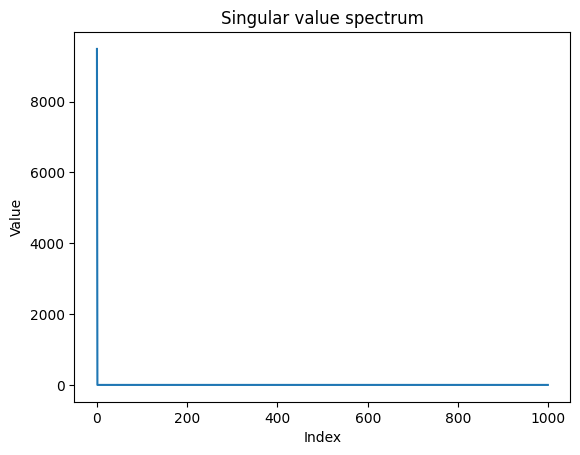

In [142]:
singular_values = np.linalg.svd(train_mat, compute_uv=False, hermitian=False)
plt.plot(singular_values)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Singular value spectrum")
plt.show()

In [146]:
def opt_rank_k_approximation(m: np.ndarray, k: int):
    """Returns the optimal rank-k reconstruction matrix, using SVD."""
    
    assert 0 < k <= np.min(m.shape), f"The rank must be in [0, min(m, n)]"
    
    U, S, Vh = np.linalg.svd(m, full_matrices=False)
    
    U_k = U[:, :k]
    S_k = S[:k]
    Vh_k = Vh[:k]
    
    return np.dot(U_k * S_k, Vh_k)


def matrix_pred_fn(train_recon: np.ndarray, sids: np.ndarray, pids: np.ndarray) -> np.ndarray:
    """
    Input:
        train_recon: (M, N) matrix with predicted values for every (sid, pid) pair.
        sids: (D,) vector with integer scientist IDs.
        pids: (D,) vector with integer paper IDs.
        
    Outputs: (D,) vector with predictions.
    """
    
    return train_recon[sids, pids]

We first obtain the optimal rank-$k$ approximation of the training matrix.

In [147]:
train_recon = opt_rank_k_approximation(train_mat, k=2)

Then, the values of this matrix reconstruction are the predictions for all (sid, pid)-pairs.

In [148]:
pred_fn = lambda sids, pids: matrix_pred_fn(train_recon, sids, pids)

# Evaluate on validation data
val_score = evaluate(valid_df, pred_fn)
print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 1.301


In [149]:
make_submission(pred_fn, "svd_submission.csv")

## Learned embeddings

Next, we will take a machine learning view of the problem. To each scientist and paper, we assign a $d$-dimensional embedding and we predict the rating that the scientist gives the paper to be their dot product. More formally, let $\vec{s}_i$ be a scientist embedding and $\vec{p}_j$ be a paper embedding. Then, we make the following rating prediction for this pair: $$\tilde{r}_{ij} = \langle \vec{s}_i, \vec{p}_j \rangle.$$ We view these embeddings as our learnable parameters and train them as we would any other model using the squared error loss function: $$\ell(\theta) = \frac{1}{2} |\langle \vec{s}_i, \vec{p}_j \rangle - r_{ij}|^2,$$ where $\theta = \{ \vec{s}_i \}_{i=1}^n \cup \{ \vec{p}_j \}_{j=1}^m$. The following is an implementation of this method.

In [384]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cpu


In [385]:
class EmbeddingDotProductModel(nn.Module):
    def __init__(self, num_scientists: int, num_papers: int, dim: int):
        super().__init__()

        # Assign to each scientist and paper an embedding
        self.scientist_emb = nn.Embedding(num_scientists, dim)
        self.paper_emb = nn.Embedding(num_papers, dim)
        
    def forward(self, sid: torch.Tensor, pid: torch.Tensor) -> torch.Tensor:
        """
        Inputs:
            sid: [B,], int
            pid: [B,], int
        
        Outputs: [B,], float
        """

        # Per-pair dot product
        return torch.sum(self.scientist_emb(sid) * self.paper_emb(pid), dim=-1)

Set $d=32$.

In [386]:
# Define model (10k scientists, 1k papers, 32-dimensional embeddings) and optimizer
model = EmbeddingDotProductModel(10_000, 1_000, 64).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [387]:
def get_dataset(
    df: pd.DataFrame,
    wishlist_df: pd.DataFrame = None
) -> torch.utils.data.Dataset:
    """
    Returns a dataset of (sid, pid, rating, wishlist_flag) for every
    (sid,pid) in ratings OR wishlist.  Missing ratings or wishlist
    entries are filled with 0.0.
    """
    # If no wishlist provided, just add an empty wishlist column
    if wishlist_df is None:
        merged = df.copy()
        merged['wishlist'] = 0.0

    else:
        # 1) Prepare the wishlist with a flag column:
        w = wishlist_df[['sid', 'pid']].copy()
        w['wishlist'] = 1.0

        # 2) Outer‐merge ratings and wishlist flags on (sid, pid):
        merged = pd.merge(
            df[['sid', 'pid', 'rating']],
            w,
            on=['sid', 'pid'],
            how='outer'       # <-- full join
        )

        # 3) Fill missing values:
        merged['rating'] = merged['rating'].fillna(0.0)
        merged['wishlist'] = merged['wishlist'].fillna(0.0)

    # 4) Convert to tensors
    sids      = torch.from_numpy(merged['sid'].to_numpy()).long()
    pids      = torch.from_numpy(merged['pid'].to_numpy()).long()
    ratings   = torch.from_numpy(merged['rating'].to_numpy()).float()
    wishlists = torch.from_numpy(merged['wishlist'].to_numpy()).float()

    return torch.utils.data.TensorDataset(sids, pids, ratings, wishlists)

In [388]:
train_dataset = get_dataset(train_ratings_df, train_wishlist_df)
valid_dataset = get_dataset(valid_ratings_df)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [389]:
class AlphaCombinedLoss(nn.Module):
    """
    L = α * MSE_on_ratings
        + (1-α) * Implicit_loss_on_wishlist

    where implicit_loss_on_wishlist = mean_{w=1}[ c * (1 - pred)^2 ].
    """
    def __init__(
        self,
        alpha: float = 0.5,
        alpha_wish: float = 1.0
    ):
        """
        alpha       : weight on the rating‐MSE term
        alpha_wish  : confidence multiplier for wishlist entries
        """
        super().__init__()
        self.alpha = alpha
        self.alpha_wish = alpha_wish

    def forward(
        self,
        preds: torch.Tensor,
        ratings: torch.Tensor,
        wishlists: torch.Tensor
    ) -> torch.Tensor:
        # 1) MSE on observed ratings
        mask_r = ratings > 0
        if mask_r.any():
            mse = F.mse_loss(preds[mask_r], ratings[mask_r])
        else:
            mse = torch.tensor(0.0, device=preds.device)

        # 2) Implicit paper loss on wishlist items only
        mask_w = wishlists > 0
        if mask_w.any():
            p = torch.ones_like(preds[mask_w])  # p_ui=1
            imp = (self.alpha_wish * (p - preds[mask_w]).pow(2)).mean()
        else:
            imp = torch.tensor(0.0, device=preds.device)

        return self.alpha * mse + (1.0 - self.alpha) * imp

In [390]:
criterion = AlphaCombinedLoss(alpha=0.8, alpha_wish=2)

Training loop, which we run for 5 epochs.

[Epoch 1/25] Train loss=54.750, Valid RMSE=2.598
[Epoch 2/25] Train loss=16.358, Valid RMSE=2.047
[Epoch 3/25] Train loss=3.759, Valid RMSE=1.550
[Epoch 4/25] Train loss=2.584, Valid RMSE=1.462
[Epoch 5/25] Train loss=2.344, Valid RMSE=1.435
[Epoch 6/25] Train loss=2.173, Valid RMSE=1.417
[Epoch 7/25] Train loss=2.029, Valid RMSE=1.418
[Epoch 8/25] Train loss=1.908, Valid RMSE=1.420
[Epoch 9/25] Train loss=1.803, Valid RMSE=1.425
[Epoch 10/25] Train loss=1.708, Valid RMSE=1.422
[Epoch 11/25] Train loss=1.626, Valid RMSE=1.428
[Epoch 12/25] Train loss=1.550, Valid RMSE=1.433
[Epoch 13/25] Train loss=1.483, Valid RMSE=1.437
[Epoch 14/25] Train loss=1.424, Valid RMSE=1.444
[Epoch 15/25] Train loss=1.369, Valid RMSE=1.443
[Epoch 16/25] Train loss=1.321, Valid RMSE=1.448
[Epoch 17/25] Train loss=1.279, Valid RMSE=1.453
[Epoch 18/25] Train loss=1.241, Valid RMSE=1.457
[Epoch 19/25] Train loss=1.205, Valid RMSE=1.461
[Epoch 20/25] Train loss=1.174, Valid RMSE=1.467
[Epoch 21/25] Train loss=1.

As we can see, this method already provides an improvement on the validation dataset over the naive SVD method.

In [195]:
pred_fn = lambda sids, pids: model(torch.from_numpy(sids).to(device), torch.from_numpy(pids).to(device)).clamp(1, 5).cpu().numpy()

# Evaluate on validation data
with torch.no_grad():
    val_score = evaluate(valid_df, pred_fn)

print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 2.984


In [18]:
with torch.no_grad():
    make_submission(pred_fn, "learned_embedding_submission.csv")

## Outlook

To further improve the score, students can make use of the information in `train_tbr.csv`, which contains the papers that scientists want to read. Furthermore, students can look into more modern collaborative filtering methods and techniques.

Have fun :)

In [ ]:
class GMF(nn.Module):
    """
    Generalized Matrix Factorization branch of NCF for research-paper recommendations.
    Computes element-wise product of researcher and paper embeddings.
    """
    def __init__(self, num_researchers: int, num_papers: int, emb_dim: int):
        super(GMF, self).__init__()
        self.researcher_emb = nn.Embedding(num_researchers, emb_dim)
        self.paper_emb      = nn.Embedding(num_papers, emb_dim)

    def forward(self, researcher_indices: torch.LongTensor, paper_indices: torch.LongTensor) -> torch.Tensor:
        # Lookup embeddings
        r = self.researcher_emb(researcher_indices)  # (batch, emb_dim)
        p = self.paper_emb(paper_indices)            # (batch, emb_dim)
        return r * p                                 # (batch, emb_dim)

In [486]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron branch of NCF for research-paper recommendations.
    Concatenates researcher and paper embeddings, then passes through dense layers.
    """
    def __init__(self, num_researchers: int, num_papers: int, emb_dim: int, mlp_layers: list[int]):
        super(MLP, self).__init__()
        self.researcher_emb = nn.Embedding(num_researchers, emb_dim)
        self.paper_emb      = nn.Embedding(num_papers, emb_dim)

        mlp_modules = []
        input_size = emb_dim * 2
        for hidden_size in mlp_layers:
            # We need to concat the researcher and paper embeddings, so the input size is doubled
            mlp_modules.append(nn.Linear(input_size, hidden_size))
            mlp_modules.append(nn.ReLU())
            input_size = hidden_size
        self.mlp = nn.Sequential(*mlp_modules)

    def forward(self, researcher_indices: torch.LongTensor, paper_indices: torch.LongTensor) -> torch.Tensor:
        r = self.researcher_emb(researcher_indices)  # (batch, emb_dim)
        p = self.paper_emb(paper_indices)            # (batch, emb_dim)
        x = torch.cat([r, p], dim=1)                 # (batch, emb_dim*2)
        out = self.mlp(x)                            # (batch, mlp_layers[-1]) 
        return out                   

In [ ]:
class NeuMF(nn.Module):
    """
    NeuMF: Fusion of GMF and MLP for research-paper recommendation.
    Outputs a predicted relevance score (e.g., probability of interest).
    """
    def __init__(
        self,
        num_researchers: int,
        num_papers: int,
        emb_dim: int,
        mlp_layers: list[int],
    ):
        super(NeuMF, self).__init__()
        
        # GMF branch
        self.gmf = GMF(num_researchers, num_papers, emb_dim)
        # MLP branch
        self.mlp = MLP(num_researchers, num_papers, emb_dim, mlp_layers)

        # Final prediction layer
        final_size = emb_dim + mlp_layers[-1]
        self.predict = nn.Linear(final_size, 1)
        self.alpha = 0.7

    def forward(self, researcher_indices: torch.LongTensor, paper_indices: torch.LongTensor) -> torch.Tensor:
        gmf_out = self.gmf(researcher_indices, paper_indices)  # GMF output: (batch, emb_dim)
        mlp_out = self.mlp(researcher_indices, paper_indices)  # MLP output: (batch, mlp_layers[-1])
        
        # Scale by alpha
        h_gmf_scaled = gmf_out * self.alpha
        h_mlp_scaled = mlp_out * (1.0 - self.alpha)

        # Concatenate and normalize
        x = torch.cat([h_gmf_scaled, h_mlp_scaled], dim=1)
        out = self.predict(x).squeeze(1)
        
        return torch.sigmoid(out) * 4.0 + 1.0


In [ ]:
# Define model (10k scientists, 1k papers, 32-dimensional embeddings) and optimizer
model = NeuMF(10_000, 1_000, 32, [64, 128, 64]).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=4e-3)

In [489]:
def get_dataset(
    df: pd.DataFrame
) -> torch.utils.data.Dataset:
    """
    Returns a dataset of triplets (researcher_id, paper_id, rating).
    """
    sids    = torch.from_numpy(df['sid'].to_numpy()).long()
    pids    = torch.from_numpy(df['pid'].to_numpy()).long()
    ratings = torch.from_numpy(df['rating'].to_numpy()).float()

    return torch.utils.data.TensorDataset(sids, pids, ratings)

# Example usage:
train_dataset = get_dataset(train_ratings_df)
valid_dataset = get_dataset(valid_ratings_df)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [490]:
NUM_EPOCHS = 25
for epoch in range(NUM_EPOCHS):
    # Train model for an epoch
    total_loss = 0.0
    total_data = 0
    model.train()
    for sid, pid, ratings in train_loader:
        # Move data to GPU
        sid = sid.to(device)
        pid = pid.to(device)
        ratings = ratings.to(device)
        wishlists = wishlists.to(device)

        # Make prediction and compute loss
        pred = model(sid, pid)
        loss = F.mse_loss(pred, ratings)

        # Compute gradients w.r.t. loss and take a step in that direction
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Keep track of running loss
        total_data += len(sid)
        total_loss += len(sid) * loss.item()

    # Evaluate model on validation data
    total_val_mse = 0.0
    total_val_data = 0
    model.eval()
    for sid, pid, ratings in valid_loader:
        sid = sid.to(device)
        pid = pid.to(device)
        ratings = ratings.to(device)

        # Clamp predictions in [1,5], since all ground-truth ratings are
        pred = model(sid, pid).clamp(1, 5)
        mse = F.mse_loss(pred, ratings)

        # Keep track of running metrics
        total_val_data += len(sid)
        total_val_mse += len(sid) * mse.item()

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train loss={total_loss / total_data:.3f}, Valid RMSE={(total_val_mse / total_val_data) ** 0.5:.3f}")

[Epoch 1/25] Train loss=0.852, Valid RMSE=0.902
[Epoch 2/25] Train loss=0.796, Valid RMSE=0.899
[Epoch 3/25] Train loss=0.778, Valid RMSE=0.892
[Epoch 4/25] Train loss=0.754, Valid RMSE=0.885
[Epoch 5/25] Train loss=0.731, Valid RMSE=0.885
[Epoch 6/25] Train loss=0.701, Valid RMSE=0.886
[Epoch 7/25] Train loss=0.670, Valid RMSE=0.885


KeyboardInterrupt: 